In [1]:
# from build_cluster import Cluster
from build_network import Network, make_input
import evaluate_input as ei
import evaluation_WTA as ev
import nest
import numpy as np
import yaml
import matplotlib.pyplot as plt

nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Load the YAML configuration once
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Simple visualisations - one run.

In [3]:
input_param = make_input(config)

net = Network(config, input_param)
net.run_simulation()

Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Built 4 clusters, each connected to its own sinusoidal input.

Jan 07 20:43:54 NodeManager::prepare_nodes [Info]: 
    Preparing 264 nodes for simulation.

Jan 07 20:43:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 264
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 07 20:43:57 SimulationManager::run [Info]: 
    Simulation finished.
Simulation completed for 1000.0 ms.

Jan 07 20:43:57 ConnectionManager [Warning]: 
    New connections created,Learning has stopped and the weights have been kept.
Delay period of <bound method Network.delay of <build_network.Network object at 0x122030050>> ms has passed, with no more connection to input and having kept the learnt w

In [4]:
# plotting the input: (emergency recycling from the test_input.ipynb)
[i_rate, i_amplitude, i_freq, trigger_input] = input_param
print( "rate:",i_rate)
print("amplitude:",i_amplitude)
print("frequency:",i_freq)

rate: [1000 1000 1000 1000]
amplitude: [1500 1500 1500 1500]
frequency: [ 5 19 22 16]


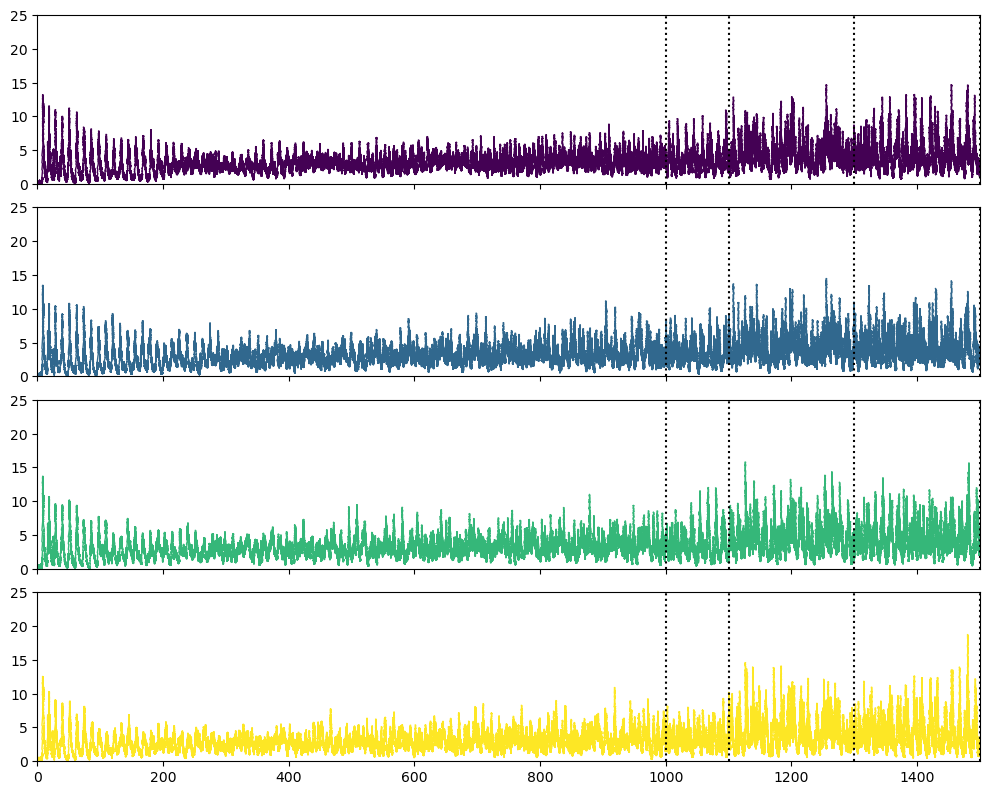

In [5]:
ev.plot_net_conductance(net)

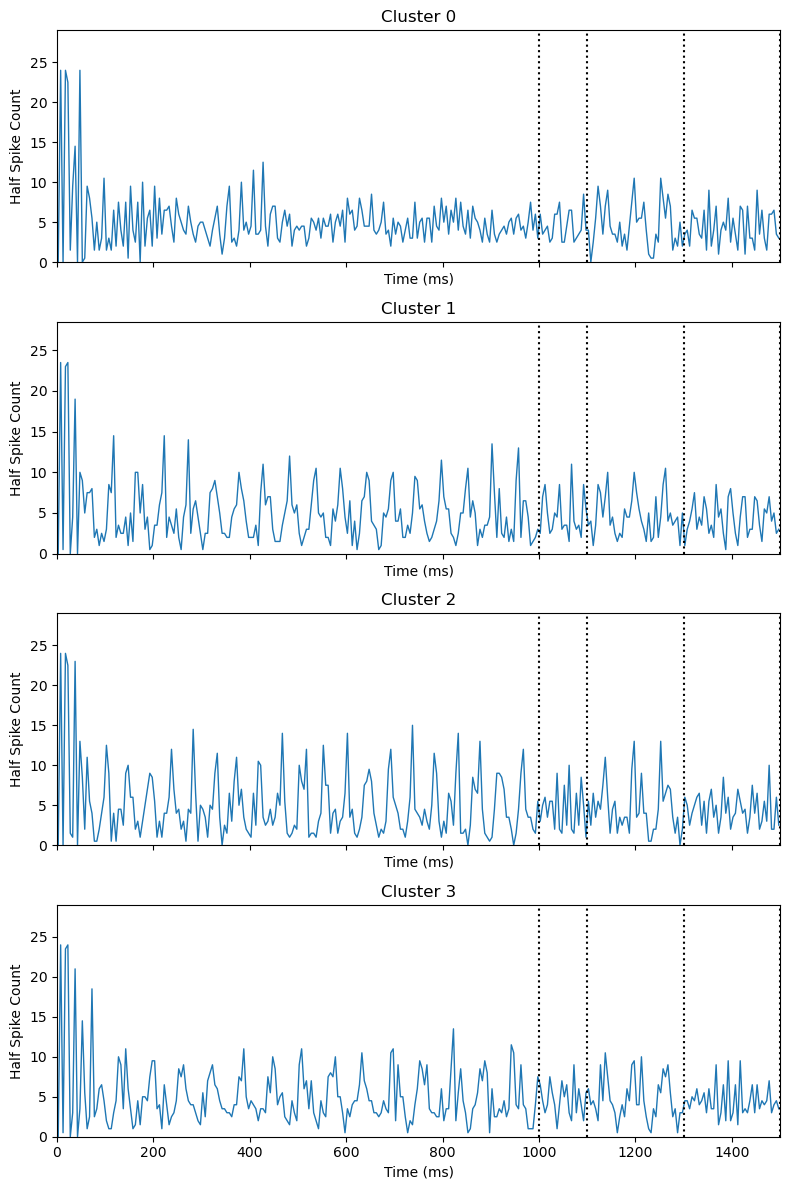

In [6]:
ev.activity_plot(net)

In [7]:
ev.get_winner(net)

Spikes in trigger period: [370, 373, 373, 378]
Spikes in test period: [351, 349, 357, 360]
Winner in trigger period: Cluster 3
Winner in test period: Cluster 3
Correct winner: Cluster 3


(3, 3, 3)

## No heterogeneiety. Is the winner correct?

Here, we will create only one input per round and repeat it n times. We have N rounds. Both values come from the configuration file.

In [8]:
per_round = config['repeats']['per_round']
rounds = config['repeats']['rounds']

correct = np.zeros((rounds, per_round))
triggered = np.zeros((rounds, per_round))
test = np.zeros((rounds, per_round))

total_iterations = rounds * per_round

for i in range(rounds):
    input_param = make_input(config)
    
    for j in range(per_round):
        net = Network(config, input_param)
        net.run_simulation()
        
        # evaluate the performance:
        winner_correct, winner_triger, winner_test = ev.get_winner(net)
        correct[i, j] = winner_correct
        triggered[i, j] = winner_triger
        test[i, j] = winner_test

        nest.ResetKernel()

        print(f'Round {i+j+1}/{total_iterations}')


Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].

Jan 07 20:44:01 ConnectionManager [Warning]: Network built successfully with heterogeneous parameters ['g_L'].

    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Network built successfully with heterogeneous parameters ['g_L'].
Built 4 clusters, each connected to its own sinusoidal input.

Jan 07 20:44:01 NodeManager::prepare_nodes [Info]: 
    Preparing 528 nodes for simulation.

Jan 07 20:44:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 528
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 07 20:44:08 SimulationManager::run [Info]: 
    Simulation finished.
Simulation completed for 1000.0 ms.

Jan 07 20:44:08 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'Get

In [9]:
# Show the results
rate_trigger, rate_test, rate_both = ev.success_rate(correct, triggered, test)

+-------------------------------------------------------------+
| Round | Trigger Match (%) | Test Match (%) | Both Match (%) |
+-------------------------------------------------------------+
|     1 |             40.00 |            0.00 |           0.00 |
|     2 |             40.00 |           40.00 |          10.00 |
+-------------------------------------------------------------+
|Overall|             40.00 |           20.00 |           5.00 |
+-------------------------------------------------------------+


In [10]:
per_round = config['repeats']['per_round']
rounds = config['repeats']['rounds']
N_clusters = config['structure']['N_clusters']

# Arrays to store the "winner" info
# shape: (rounds, per_round)
correct = np.zeros((rounds, per_round), dtype=int)
triggered = np.zeros((rounds, per_round), dtype=int)
tested = np.zeros((rounds, per_round), dtype=int)

# For spike accumulation, we need shape: (rounds, per_round, N_clusters)
all_trigger_spikes = np.zeros((rounds, per_round, N_clusters))
all_test_spikes    = np.zeros((rounds, per_round, N_clusters))

total_iterations = rounds * per_round
iter_count = 0

for i in range(rounds):
    # Make the sinusoidal inputs for this round
    input_param = make_input(config)

    # Now do 'per_round' repeats
    for j in range(per_round):
        iter_count += 1

        # Build and run network
        net = Network(config, input_param)
        net.run_simulation()

        # Evaluate the performance
        winner_correct, winner_trig, winner_t, spk_trig, spk_test = ev.get_winner_extended(net)
        
        # Store
        correct[i, j] = winner_correct
        triggered[i, j] = winner_trig
        tested[i, j] = winner_t
        all_trigger_spikes[i, j, :] = spk_trig
        all_test_spikes[i, j, :]    = spk_test

        # Reset kernel so next repeat is fresh
        nest.ResetKernel()

        print(f'Completed Round {i+1}/{rounds}, Repeat {j+1}/{per_round} (Global {iter_count}/{total_iterations}).')

    # Now that the round is done, we can do a round-level summary:
    ev.summarize_round(
        round_index=i,
        winner_correct_list=correct[i, :],
        winner_trigger_list=triggered[i, :],
        winner_test_list=tested[i, :],
        all_trigger_spikes=all_trigger_spikes[i, :, :],
        all_test_spikes=all_test_spikes[i, :, :]
    )

# Finally, if you still want an overall success rate ignoring the 
# round-level details, you can do something like:
rate_trigger, rate_test, rate_both = ev.success_rate(correct, triggered, tested)
print(f"Overall success rates -> Trigger: {rate_trigger:.2f}%, Test: {rate_test:.2f}%, Both: {rate_both:.2f}%")

Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Network built successfully with heterogeneous parameters ['g_L'].
Built 4 clusters, each connected to its own sinusoidal input.

Jan 07 20:45:36 NodeManager::prepare_nodes [Info]: 
    Preparing 264 nodes for simulation.

Jan 07 20:45:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 264
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 07 20:45:39 SimulationManager::run [Info]: 
    Simulation finished.
Simulation completed for 1000.0 ms.

Jan 07 20:45:39 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.

Jan 07 20:45:39 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'Get

# Vary CVs. How does it behave?

## $g_{L}$

# $C{m}$

In [15]:
print(config["CV"]["C_m"])

# setting up the repeats
nr_repeats = 5


CV_incr = np.linspace(0.0, 0.3, 10)

correct_winner = [[] for _ in CV_incr]
trigger_winner = [[] for _ in CV_incr]
test_winner = [[] for _ in CV_incr]

trigger_success = []
test_success = []
both_success = []

0.0


In [16]:
# ev.run_CV_experiments(config)


======= Running for C_m = 0.0 =======


TypeError: 'module' object is not callable

In [19]:
for i, cv in enumerate(CV_incr):
    # Update config
    config["CV"]["g_L"] = cv

    # Inner loop: repeat experiment nr_repeats times
    for rep in range(nr_repeats):
        # Setup network
        net = Network(config, input_param)

        # Run simulation
        net.run_simulation()

        # Get results
        correct_winner[i].append(net.winner)
        winner_triger, winner_test, winner_correct = ev.get_winner(net)
        trigger_winner[i].append(winner_triger)
        test_winner[i].append(test)

        # Ready for next iteration
        nest.ResetKernel()

    # After finishing repeats for this c_m_val, compute success rates
    rate_trigger, rate_test, rate_both = ev.success_rate(
        correct_winner[i], 
        trigger_winner[i], 
        test_winner[i]
    )

    # Store them for later plotting or analysis
    trigger_success.append(rate_trigger)
    test_success.append(rate_test)
    both_success.append(rate_both)



Jan 07 20:54:02 ConnectionManager [Warning]: 
    New connections created, connNetwork built successfully with heterogeneous parameters [].
Network built successfully with heterogeneous parameters [].
Network built successfully with heterogeneous parameters [].
ection descriptors previously obtained using 
    'GetConnections' are now invalid.
Network built successfully with heterogeneous parameters [].
Built 4 clusters, each connected to its own sinusoidal input.
Simulation completed for 1000.0 ms.

Jan 07 20:54:02 NodeManager::prepare_nodes [Info]: 
    Preparing 528 nodes for simulation.

Jan 07 20:54:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 528
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 07 20:54:08 SimulationManager::run [Info]: 
    Simulation finished.

Jan 07 20:54:08 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now

AttributeError: 'list' object has no attribute 'shape'

In [14]:
plt.plot(CV_incr, trigger_success, label="Trigger Success (%)")
plt.plot(CV_incr, test_success,    label="Test Success (%)")
plt.plot(CV_incr, both_success,    label="Both Success (%)")

plt.xlabel("C_m Values")
plt.ylabel("Success Rate (%)")
plt.legend()
plt.show()

## Troubleshooting